# GreenValueNet

This notebook contains the code needed to execute the GreenValueNet hedonic pricing neural network. 

### Set up and data loading

In [1]:
import joblib
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from data_load_funcs import get_params, load_data_catalogue
from processing_funcs import process_data, normalise_values
from model_funcs import *

cwd = Path.cwd()
params = get_params()
data_catalogue = load_data_catalogue()

The `dataset.csv` file from `data/interim_files` is loaded if it already exists, or constructed if not. To build the dataset please follow the steps in [Annex 1 of the ReadMe file](readme.md#annex-1) to esnure all relevant files have been downloaded. 

In [2]:
dataset = process_data(data_catalogue, params)

# show summary stats
summary_stats = dataset.describe().transpose()[['mean', 'std', 'max', 'min']]
summary_stats.columns = ['Mean', 'Std Dev', 'Maximum', 'Minimum']
print(summary_stats)

Processed dataset already exists.
Loading exisitng dataset...
                                  Mean    Std Dev       Maximum   Minimum
ln_price                     12.393713   0.658136     18.134158  0.116855
propertytype                  1.328094   1.085676      3.000000  0.000000
oldnew                        0.134435   0.341119      1.000000  0.000000
duration                      0.325202   0.468482      2.000000  0.000000
current_energy_efficiency    61.056443  12.444568    347.000000  0.000000
potential_energy_efficiency   0.805024   0.140106      1.000000  0.000000
total_floor_area             91.622326  68.669650  60506.700000  0.000000
extension_count               0.495053   0.743755      4.000000  0.000000
number_habitable_rooms        4.521529   1.748808    100.000000  0.000000
number_heated_rooms           4.437662   1.754007    100.000000  0.000000
construction_age_band         4.477500   3.153767     10.000000 -1.000000
coastline_dist               57.173176  38.518186 

In [4]:
print(dataset.shape)
print(dataset.isnull().sum())

(12909200, 26)
transactionid                  0
ln_price                       0
postcode                       0
propertytype                   0
oldnew                         0
duration                       0
current_energy_efficiency      0
potential_energy_efficiency    0
total_floor_area               0
extension_count                0
number_habitable_rooms         0
number_heated_rooms            0
construction_age_band          0
coastline_dist                 0
prim_school_dist               0
sec_school_dist                0
roads_dist                     0
nat_park_dist                  0
nat_trust_dist                 0
ttwa_dist                      0
dom_builds_share               0
garden_share                   0
non_dom_builds_share           0
path_share                     0
greenspace_share               0
water_share                    0
dtype: int64


Now we normalise any non-encoded variables to increase speed of learning of algorithm and convert the dataset to an array of inputs, and an associated output array.

In [3]:
norm_cols = [col for col in dataset.columns if col not in params['non_norm_cols']]
for col in norm_cols:
    dataset[col] = normalise_values(dataset[col])

# creates an input array of shape m,x and an output array of shape m
x, y, derivative_index = create_x_y_arr(dataset, params)

The dataset is then split into train, dev and test sets using sci-kit learn.

In [18]:
x_train, x_dev, x_test, y_train, y_dev, y_test = split_to_test_dev_train(
    x,
    y,
    params['dev_size'],
    params['test_size'],
    prop=False
)

## Benchmarking

To evaluate the performance of my neural network we use random forest and XGBoost regressions as baseline models. We optimise based on the mean squared error (MSE) and report this as our measure of performance.

### Random Forest


In [8]:
# run baseline random forest regression using scikit-learn
rfr_model = random_forest_reg(
    x_train,
    y_train,
    tuning=False
)

# now run with grid search to tune parameters
# rfr_tuned  =  random_forest_reg(
#     x_train,
#     y_train,
#     tuning=True,
#     tuning_params = params['tuning_dict']['grid']
# )

# generate predictions and measure according to mean squared error
rfr_pred, rfr_mse = generate_pred_metric(rfr_model, mean_squared_error, x_dev, y_dev)
# rfr_t_pred, rfr_t_mse = generate_pred_metric(rfr_tuned, mean_squared_error, x_dev, y_dev)

### XGBoost

In [9]:
xgb_model = boosted_grad_reg(x_train, y_train)
xgb_pred, xgb_mse = generate_pred_metric(xgb_model, mean_squared_error, x_dev, y_dev)

## Neural networks

We know build some neural networks. Number of epochs, hidden layers, and nodes in hidden layers is initially set with rules of thumb but then optimiszed using hyperparameter tuning.

In [11]:
# set epochs to be 3 times number of features
epochs = int(x_train.shape[1]) * 3

# set n_hidden_units to be mean of input and output layer sizes
n_hidden_units = round((x_train.shape[1] + 1) / 2)

### Single Layer Neural Network

A single hidden layer with ReLU activation is used with a linear output layer.

In [13]:
single_nn = neural_net(
    x_train,
    y_train,
    learning_rate = 0.05,
    n_hidden_units = n_hidden_units,
    epochs = epochs,
    validation_data = (x_dev, y_dev)
)

Epoch 1/69
402788/402788 [==============================] - 137s 338us/step - loss: 0.2617 - mae: 0.3905 - val_loss: 0.2431 - val_mae: 0.3735
Epoch 2/69
402788/402788 [==============================] - 137s 341us/step - loss: 0.2566 - mae: 0.3894 - val_loss: 0.2472 - val_mae: 0.3744
Epoch 3/69
402788/402788 [==============================] - 138s 342us/step - loss: 0.2566 - mae: 0.3894 - val_loss: 0.2595 - val_mae: 0.3770
Epoch 4/69
402788/402788 [==============================] - 137s 340us/step - loss: 0.2639 - mae: 0.3949 - val_loss: 0.2950 - val_mae: 0.4027
Epoch 5/69
402788/402788 [==============================] - 138s 342us/step - loss: 0.2676 - mae: 0.3978 - val_loss: 0.2674 - val_mae: 0.3878
Epoch 6/69
402788/402788 [==============================] - 137s 340us/step - loss: 0.2676 - mae: 0.3978 - val_loss: 0.2606 - val_mae: 0.3847
Epoch 7/69
402788/402788 [==============================] - 138s 342us/step - loss: 0.2676 - mae: 0.3978 - val_loss: 0.2667 - val_mae: 0.3864
Epoch 

In [19]:
single_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                288       
                                                                 
 batch_normalization (Batch  (None, 12)                48        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 349 (1.36 KB)
Trainable params: 325 (1.27 KB)
Non-trainable params: 24 (96.00 Byte)
_________________________________________________________________


### Deep Neural Network

The full model is specified as a deep neural network using layers with ReLU activation functions with a linear activation in the output layer. The choice of number of layers was initially kept small due to computational processing constraints.

In [14]:
deep_nn = neural_net(
    x_train,
    y_train,
    n_layers = 10,
    n_hidden_units = n_hidden_units,
    epochs = epochs,
    validation_data = (x_dev, y_dev)
)

Epoch 1/69
402788/402788 [==============================] - 389s 962us/step - loss: 0.2222 - mae: 0.3527 - val_loss: 0.1862 - val_mae: 0.3292
Epoch 2/69
402788/402788 [==============================] - 382s 948us/step - loss: 0.1982 - mae: 0.3413 - val_loss: 0.1831 - val_mae: 0.3248
Epoch 3/69
402788/402788 [==============================] - 381s 947us/step - loss: 0.1971 - mae: 0.3403 - val_loss: 0.1892 - val_mae: 0.3381
Epoch 4/69
402788/402788 [==============================] - 383s 952us/step - loss: 0.1966 - mae: 0.3398 - val_loss: 0.1864 - val_mae: 0.3343
Epoch 5/69
402788/402788 [==============================] - 383s 950us/step - loss: 0.1962 - mae: 0.3395 - val_loss: 0.2039 - val_mae: 0.3565
Epoch 6/69
402788/402788 [==============================] - 383s 950us/step - loss: 0.1960 - mae: 0.3393 - val_loss: 0.1832 - val_mae: 0.3224
Epoch 7/69
402788/402788 [==============================] - 384s 954us/step - loss: 0.1957 - mae: 0.3390 - val_loss: 0.1817 - val_mae: 0.3187
Epoch 

In [18]:
deep_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12)                288       
                                                                 
 batch_normalization_1 (Bat  (None, 12)                48        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 batch_normalization_2 (Bat  (None, 12)                48        
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 12)               

## Results

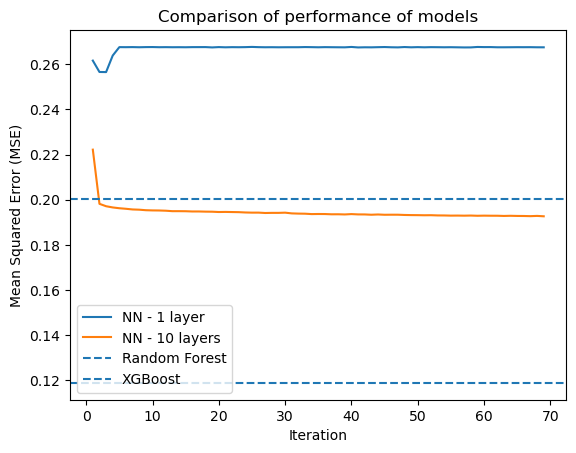

In [20]:
nn_dict = {
    # 'NN - 1 layer': single_nn.history.history['loss'],
    'NN - 10 layers': deep_nn.history.history['loss']
}
baseline_dict = {
    'Random Forest': rfr_mse,
    # 'Random Forest (tuned)': rfr_t_mse,
    'XGBoost': xgb_mse
}

generate_plot(nn_dict, baseline_dict, save=True, name='model_mse_240120.png')

### Calculating marginal valuation of environmental attributes

Once we have a model with environmental attributes as features and log of house price as the target variable, we can begin to construct the marginal willingness to pay for environmental attributes, and therefore get a proxy for their value.

The partial derivative of `ln_price` w.r.t an input variable can be evaluated during the backwards propagation stage of the model fitting. By evaluating this derivative at a variety of samples, we can plot a valulation curve for the change in $ln(price)$ for a change in the input feature by 1 standard deviation.

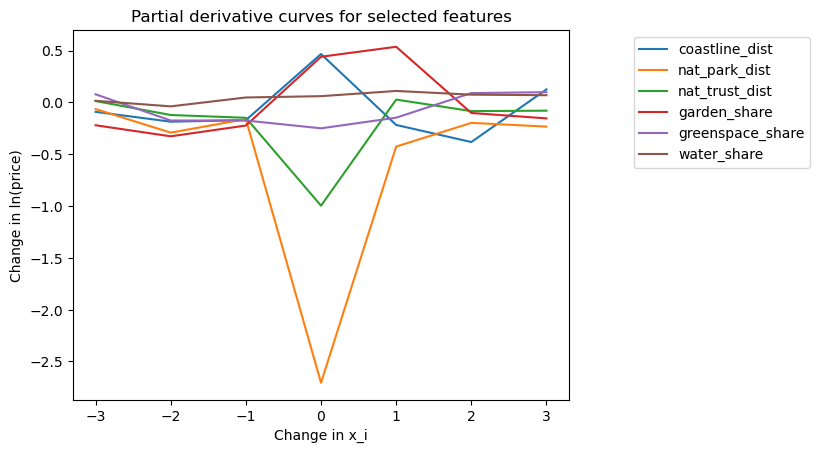

In [41]:
# extract the gradients from the model
points = np.arange(-3, 4, 1)
gradients = calc_partial_grad(
    deep_nn,
    x_dev,
    derivative_index,
    points)
gradients.shape

plot_partial_grads(gradients, points, derivative_index, save=True, name='partial_grads_240206.png')

In [40]:
def plot_partial_grads(
        gradients: np.ndarray,
        points_to_eval: np.ndarray,
        derivative_index: zip
):
    """
    This function takes the partial gradient
    array and plots each features partial gradient
    curve over the range of points to eval
    """
    for col, (label, old_index) in enumerate(derivative_index):
        y_values = gradients[:, col]
        plt.plot(points_to_eval, y_values, label=label)
    plt.xlabel('Change in x_i')
    plt.ylabel('Change in ln(price)')
    plt.title('Partial derivative curves for selected features')
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

    plt.show()

### Saving models

Here we save the pre-trained models so they can be loaded and used.

In [22]:
model_dir = cwd / "outputs" / "models"

# save models as tensor objects
deep_nn.save(model_dir / "nn_layers_10.keras")
single_nn.save(model_dir / "nn_layers_1.keras")

# save models as joblib files
# joblib.dump(rfr_model, model_dir / "random_forest.joblib")
# joblib.dump(rfr_t_model, model_dir / "random_forest_tuned.joblib")
# joblib.dump(xgb_model, model_dir / "xgboost.joblib")